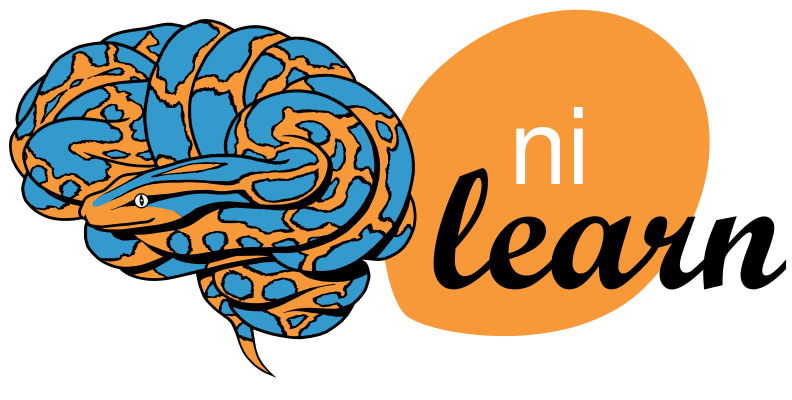

In [1]:
from IPython.display import Image
Image(filename='../images/nilearn-logo.png') 

# Creating a connectome with [`nilearn`](http://nilearn.github.io)

This is the second notebook of this tutorial in which we will use nilearn to create a connectome from real data.

<div class="alert alert-block alert-warning">
<b>Warning:</b> Make sure you have run and understood the introduction notebook <em>01-introduction.ipynb</em> before diving into this one.
</div>

In [2]:
# Silence warnings to prettify outputs
import warnings
warnings.filterwarnings("ignore")

## Outline

- <a href="#data">Why do we need a specialized tool to work with neuroimaging data?</a>
- <a href="#subsetting">Getting into the data: subsetting and viewing</a>
- <a href="#extracting">Extracting signal from fMRI volumes</a>
    - <a href="#roi">Choosing regions of interest</a>
    - <a href="#nifti-zoo">A quick side-note on the NiftiMasker zoo</a>
    - <a href="#apply-masker">Applying a Masker object</a>
    - <a href="#dim">Dimensions, dimensions</a>
- <a href="#connectome">Creating and viewing a connectome</a>
- <a href="#noise">Accounting for noise sources</a>

<span id="data"></span>

## Why do we need a specialized tool to work with neuroimaging data?

First of all, let's briefly consider why we might want specialized tools for working with neuroimaging data.

When performing a machine learning analysis, our data often look something like this:

In [3]:
import pandas as pd

# read_csv can read in just about any plain-text tabular data
data = pd.read_csv('./data/abide2.tsv', sep='\t')
data.head()

site  subject        age  age_resid  sex  group  fsArea_L_V1_ROI  \
0   ABIDEII-KKI_1    29293   8.893151  13.642852  2.0    1.0           2750.0   
1  ABIDEII-OHSU_1    28997  12.000000  16.081732  2.0    1.0           2836.0   
2    ABIDEII-GU_1    28845   8.390000  12.866264  1.0    2.0           3394.0   
3   ABIDEII-NYU_1    29210   8.300000  13.698139  1.0    1.0           3382.0   
4   ABIDEII-EMC_1    29894   7.772758  14.772459  2.0    2.0           3080.0   

   fsArea_L_MST_ROI  fsArea_L_V6_ROI  fsArea_L_V2_ROI  ...  fsCT_R_p47r_ROI  \
0             306.0            354.0           2123.0  ...            3.362   
1             186.0            354.0           2261.0  ...            2.809   
2             223.0            373.0           2827.0  ...            2.435   
3             266.0            422.0           2686.0  ...            3.349   
4             161.0            346.0           2105.0  ...            2.428   

   fsCT_R_TGv_ROI  fsCT_R_MBelt_ROI  fsCT_R_LBelt_ROI  fsCT_R_A4_ROI  \
0           2.827             2.777             2.526          3.202   
1           3.539             2.944             2.769          3.530   
2           3.321             2.799             2.388          3.148   
3           3.344             2.694             3.030          3.258   
4           2.940             2.809             2.607          3.430   

   fsCT_R_STSva_ROI  fsCT_R_TE1m_ROI  fsCT_R_PI_ROI  fsCT_R_a32pr_ROI  \
0             3.024            3.354          2.629             2.699   
1             3.079            3.282          2.670             2.746   
2             3.125            3.116          2.891             2.940   
3             2.774            3.383          2.696             3.014   
4             2.752            2.645          3.111             3.219   

   fsCT_R_p24_ROI  
0           3.179  
1           3.324  
2           3.232  
3           3.264  
4           4.128  

[5 rows x 1446 columns]

For our purposes, what's most interesting is the structure of this data set. That is, the data is structured in a tabular format, with pre-extracted features of interest. In the machine learning world, the rows are usually called *samples* while columns refer to *features*.

This makes it easier to consider issues such as: which features would we like to predict? Or, how should we handle cross-validation?

But if we're starting with neuroimaging data, how can create this kind of structured representation?

### Neuroimaging data

Neuroimaging data does not have a tabular structure. Instead, it has both **spatial and temporal dependencies** between successive data points. That is, knowing _where_ and _when_ something was measured tells you information about the surrounding data points.

We also know that neuroimaging data contains a lot of noise that's not blood-oxygen-level dependent (BOLD), such as head motion. Since we don't think that these other noise sources are related to neuronal firing, we often need to consider how we can make sure that our analyses are not driven by these noise sources.

These are all considerations that most machine learning software libraries are not designed to deal with! Nilearn therefore plays a crucial role in bringing machine learning concepts to the neuroimaging domain.

### Let's get our hands dirty!

To get a sense of the problem, the quickest method is to just look at some data. You may have your own data locally that you'd like to work with. As we saw in the introduction notebook, the [`datasets`](https://nilearn.github.io/modules/reference.html#module-nilearn.datasets) module of Nilearn also provides utilities to easily download several neuroimaging data sets and atlases.

<div class="alert alert-block alert-success">
These data sets (and atlases) are only accessible because research groups chose to make their collected data publicly available. We owe them a huge thank you for this!
</div>

The data set we'll use today was originally collected by [Rebecca Saxe](https://mcgovern.mit.edu/profile/rebecca-saxe/)'s group at MIT and hosted on [OpenNeuro](https://openneuro.org/datasets/ds000228/versions/1.1.0).

The nilearn team preprocessed the data set with [fMRIPrep](https://fmriprep.readthedocs.io) and downsampled it to a lower resolution, so it'd be easier to work with.

We can learn a lot about this data set directly [from the Nilearn documentation](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_development_fmri.html).

For example, we can see that this data set contains over 150 children and adults watching a short Pixar film.

Let's download the first 30 participants:

In [4]:
from nilearn import datasets

development_dataset = datasets.fetch_development_fmri(n_subjects=30)
development_dataset.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

Now, this `development_dataset` object has several attributes which provide access to the relevant information.

For example, `development_dataset.phenotypic` provides access to information about the participants, such as whether they were children or adults.

`development_dataset.func` holds the functional MRI (fMRI) data. If you look at it, you will see that it is a list of 30 strings, where each string is a path to a file holding the images for a specific subject:

In [5]:
len(development_dataset.func)

30

Let's have a closer look at the fMRI data of the first subject. As we saw previously, we can use functions from the [`image`](https://nilearn.github.io/modules/reference.html#module-nilearn.image) module, for example [`image.load_img`](https://nilearn.github.io/modules/generated/nilearn.image.load_img.html):

In [6]:
from nilearn import image

img = image.load_img(development_dataset.func[0])
img.shape

(50, 59, 50, 168)

This means that, for the first subject, there are 168 volumes, each with a 3D structure of (50, 59, 50).

<span id="subsetting"></span>

## Getting into the data: subsetting and viewing

As we saw in the introduction notebook, Nilearn provides many methods for plotting this kind of data.

We already saw [`nilearn.plotting.plot_img`](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_img.html) to display a static view of our image. Here we can use [`nilearn.plotting.view_img`](https://nilearn.github.io/modules/generated/nilearn.plotting.view_img.html) to launch at interactive viewer.

On the contrary to the MNI 152 template image of the introduction notebook which was a 3D image, each fMRI run here is a 4D time series (three spatial dimensions plus time). This means that we will also need to subset the data when we plot it, so that we can look at a single 3D image.

Nilearn provides (at least) two ways to do this:

- with [`nilearn.image.index_img`](https://nilearn.github.io/modules/generated/nilearn.image.index_img.html),
which allows us to index a particular frame--or several frames--of a time series,
- and with [`nilearn.image.mean_img`](https://nilearn.github.io/modules/generated/nilearn.image.mean_img.html),
which allows us to take the mean 3D image over time.

Putting these together, we can interatively view the mean image of the first participant using:


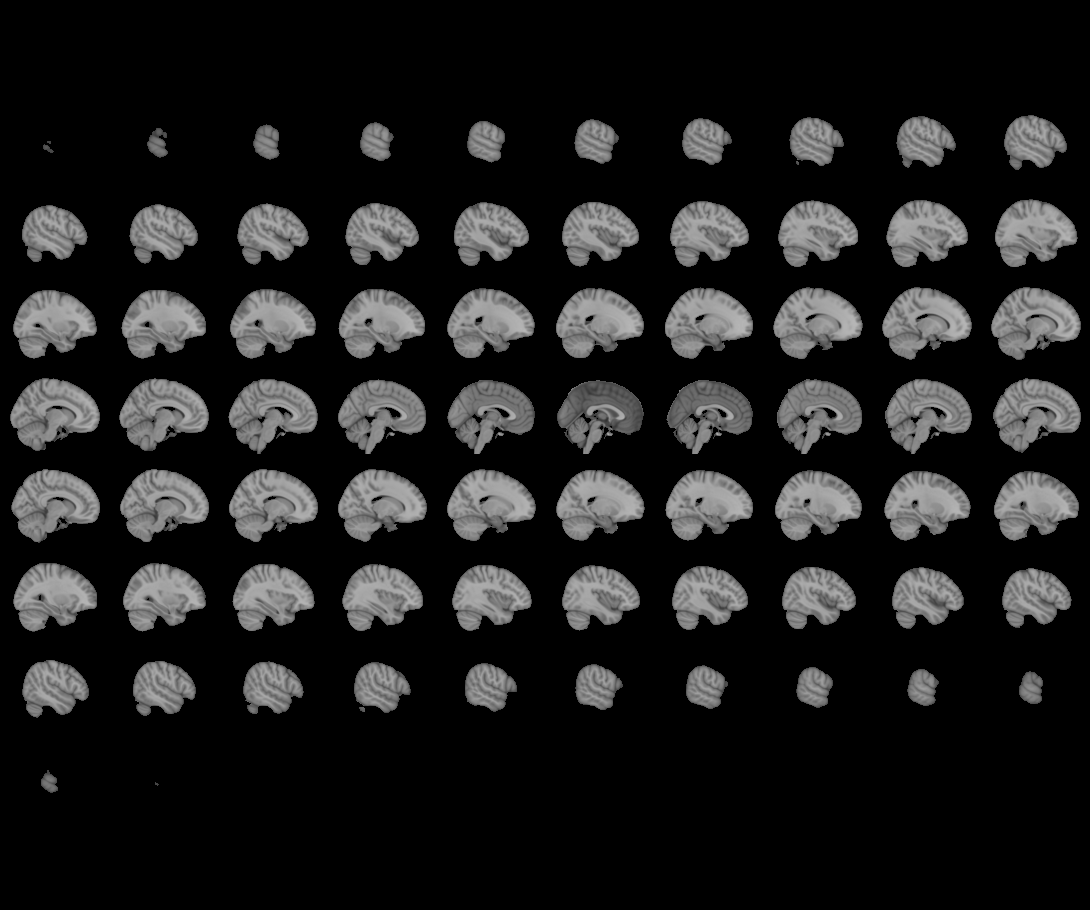
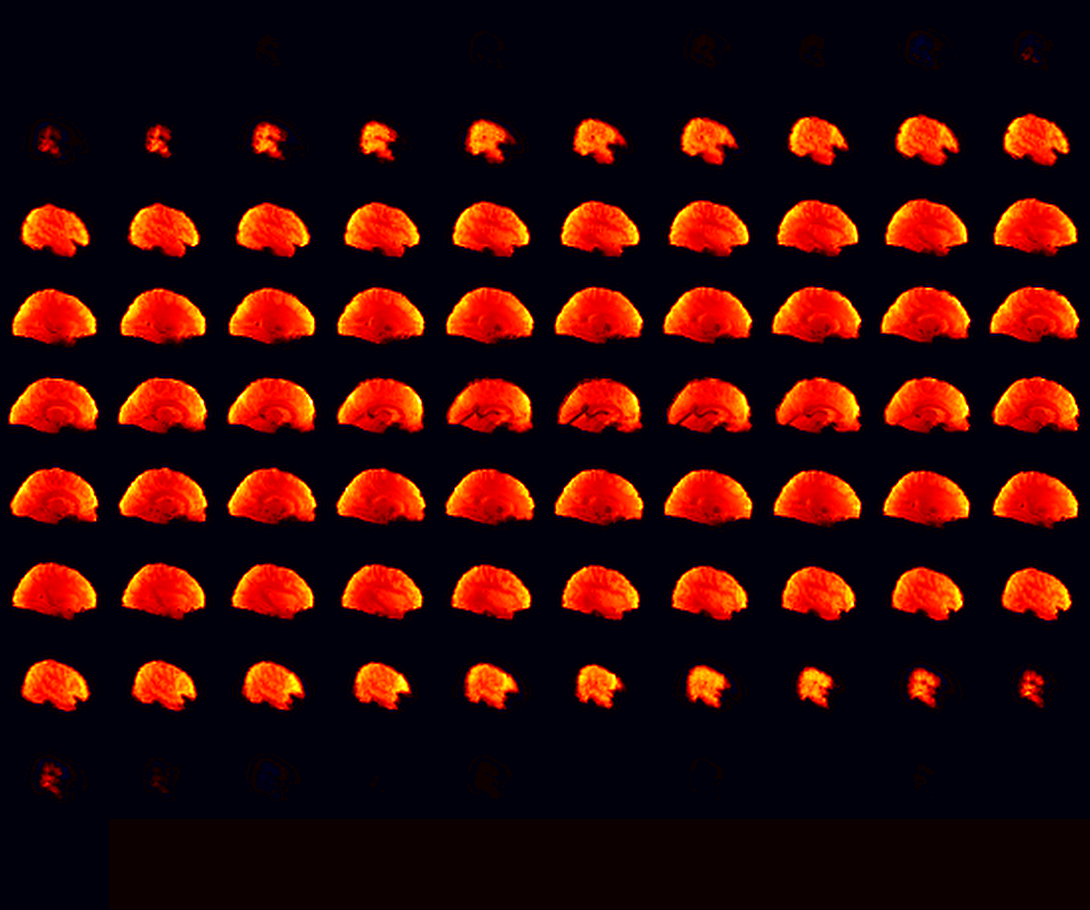

In [7]:
from nilearn import plotting

mean_image = image.mean_img(img) # mean_image is 3D
plotting.view_img(mean_image, threshold=None)

<span id="extracting"></span>

## Extracting signal from fMRI volumes

As you can see, this data is decidedly not tabular!

What we would like is to extract and transform meaningful features from this data, and store it in a format that we can easily work with. Importantly, we _could_ work with the full time series directly. But we often want to reduce the dimensionality of our data in a structured way. That is, we may only want to consider signal within certain learned or pre-defined regions of interest (ROIs), and when taking into account known sources of noise. To do this, we'll use nilearn's Masker objects.

**What are the masker objects ?**

First, let's think about what masking fMRI data is doing:

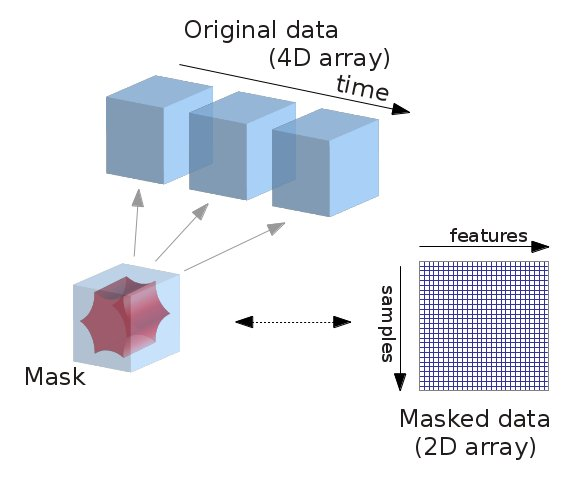

In [8]:
from IPython.display import Image
Image(filename='../images/masking.jpg') 

Essentially, we can imagine overlaying a 3D grid on an image. Then, our mask tells us which cubes or “voxels” (like 3D pixels) to sample from.

Since our Nifti images are 4D files, we can’t overlay a single grid – instead, we use a series of 3D grids (one for each volume in the 4D file), so we can get a measurement for each voxel at each timepoint.

Masker objects allow us to apply these masks!

To start, we need to define a mask (or masks) that we'd like to apply. This could correspond to one or many regions of interest.

Nilearn provides methods to define your own functional parcellation (using clustering algorithms such as _k-means_), and it also provides access to other atlases that have previously been defined by researchers.

<span id="roi"></span>

### Choosing regions of interest

In this tutorial, we will use the MSDL (multi-subject dictionary learning, `Varoquaux_2011`) atlas, which defines a set of _probabilistic_ ROIs across the brain. 

<div class="alert alert-block alert-info">
<b>Tip:</b> Nilearn ships with several atlases commonly used in the field, including the Schaefer atlas and the Harvard-Oxford atlas.
</div>

To download the MSDL atlas, we rely on the function [`nilearn.datasets.fetch_atlas_msdl`](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_msdl.html):

In [9]:
import numpy as np

msdl_atlas = datasets.fetch_atlas_msdl()
msdl_atlas.keys()

dict_keys(['maps', 'labels', 'region_coords', 'networks', 'description'])

In [10]:
msdl_coords = msdl_atlas.region_coords
n_regions = len(msdl_coords)

print(f'MSDL has {n_regions} ROIs, part of the following networks :\n{np.unique(msdl_atlas.networks)}.')

MSDL has 39 ROIs, part of the following networks :
[b'Ant IPS' b'Aud' b'Basal' b'Cereb' b'Cing-Ins' b'D Att' b'DMN'
 b'Dors PCC' b'L V Att' b'Language' b'Motor' b'Occ post' b'R V Att'
 b'Salience' b'Striate' b'Temporal' b'Vis Sec'].


`msdl_atlas.maps` contains a string which is the path to the maps images. You can have a look at them as you would with any other image:

In [11]:
# Notice the data is 4D
image.load_img(msdl_atlas.maps).shape

(40, 48, 35, 39)

As you can see, MSDL is a probabilistic atlas. We can view it using the function [`nilearn.plotting.plot_prob_atlas`](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_prob_atlas.html):

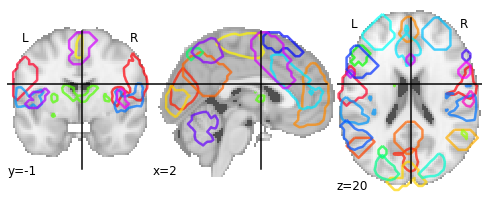

In [12]:
plotting.plot_prob_atlas(msdl_atlas.maps)

<span id="nifti-zoo"></span>

### A quick side-note on the NiftiMasker zoo

We would like to supply these ROIs to a `Masker` object. All Masker objects share the same basic structure and functionality,
but each is designed to work with a different kind of ROI. Masker objects are defined in the [`input_data`](https://nilearn.github.io/modules/reference.html#module-nilearn.input_data) module of nilearn.

The canonical [`nilearn.input_data.NiftiMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html) works well if we want to apply a single mask to the data, like a single region of interest.

But what if we actually have several ROIs that we'd like to apply to the data all at once?

If these ROIs are non-overlapping, as in "hard" or deterministic parcellations, then we can use [`nilearn.input_data.NiftiLabelsMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiLabelsMasker.html).

Because we are working with "soft" or probabilistic ROIs, we can instead supply these ROIs to [`nilearn.input_data.NiftiMapsMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMapsMasker.html).

For a full list of the available Masker objects, see [the Nilearn documentation](https://nilearn.github.io/modules/reference.html#module-nilearn.input_data).

<span id="apply-masker"></span>

### Applying a Masker object

We can supply our MSDL atlas-defined ROIs to the `NiftiMapsMasker` object, along with resampling, filtering, and detrending parameters.

In [13]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(msdl_atlas.maps,
                                    resampling_target="data",
                                    t_r=2, detrend=True,
                                    low_pass=0.1, high_pass=0.01).fit()

One thing you might notice from the above code is that immediately after defining the masker object, we call the `.fit` method on it. This method may look familiar if you've previously worked with scikit-learn estimators!

You'll note that we're not supplying any data to this `.fit` method; that's because we're fitting the Masker to the provided ROIs, rather than to our data.

<span id="dim"></span>

### Dimensions, dimensions

We can use this fitted masker to `transform` our data.

In [14]:
roi_time_series = masker.transform(development_dataset.func[0])
roi_time_series.shape

(168, 39)

If you'll remember, when we first looked at the data its original dimensions were (50, 59, 50, 168).
Now, it has a shape of (168, 39).
What happened?!

Rather than providing information on every voxel within our original 3D grid,
we're now only considering those voxels that fall in our 39 regions of interest provided by the MSDL atlas and aggregating across voxels within those ROIS.
This reduces each 3D volume from a dimensionality of (50, 59, 50) to just 39,
for our 39 provided ROIs.

You'll also see that the "dimensions flipped;"
that is, that we've transposed the matrix such that time is now the first rather than second dimension.
This follows the scikit-learn convention that rows in a data matrix are _samples_,
and columns in a data matrix are _features_.

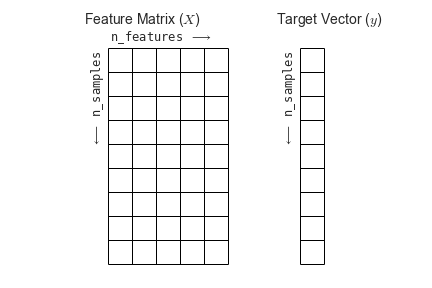

In [15]:
Image(filename="../images/samples-features.png")

```
---
The scikit-learn conventions for feature and target matrices.
From Jake VanderPlas's _Python Data Science Handbook_.
```

<div class="alert alert-block alert-success">
One of the nice things about working with nilearn is that it will impose this convention for you, so you don't accidentally flip your dimensions when using a scikit-learn model!
</div>

<span id="connectome"></span>

## Creating and viewing a connectome

The simplest and most commonly used kind of functional connectivity is pairwise correlation between ROIs.

We can estimate it using [`nilearn.connectome.ConnectivityMeasure`](https://nilearn.github.io/modules/generated/nilearn.connectome.ConnectivityMeasure.html).

In [16]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([roi_time_series])[0]

We can then plot this functional connectivity matrix using the function [`nilearn.plotting.plot_matrix`](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_matrix.html):

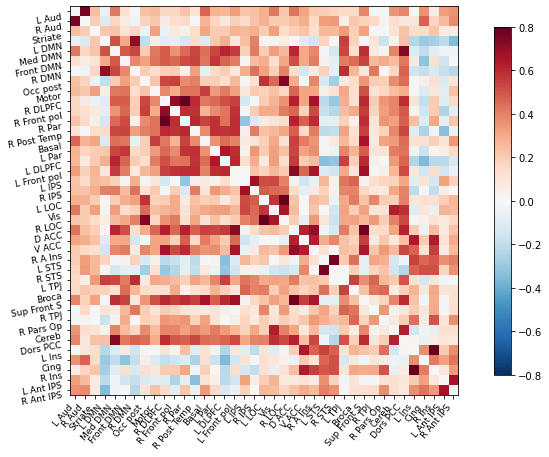

In [17]:
import matplotlib.pyplot as plt

def set_tick_label_size(figure, fontsize):
    """Make tick labels more visible."""
    for xtick,ytick in zip(fig.axes[0].xaxis.get_major_ticks(),
                           fig.axes[0].yaxis.get_major_ticks()):
        xtick.label.set_fontsize(9)
        ytick.label.set_fontsize(9)

np.fill_diagonal(correlation_matrix, 0)
fig = plt.figure(figsize=(8, 8))
plotting.plot_matrix(correlation_matrix, labels=msdl_atlas.labels,
                     vmax=0.8, vmin=-0.8, colorbar=True, figure=fig)
set_tick_label_size(fig, 9)

Or view it as an embedded connectome using the function [`nilearn.plotting.view_connectome`](https://nilearn.github.io/modules/generated/nilearn.plotting.view_connectome.html):

In [18]:
plotting.view_connectome(correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

<span id="noise"></span>

## Accounting for noise sources

As we have already seen, maskers also allow us to perform other useful operations beyond just masking our data. One important processing step is correcting for measured signals of no interest (e.g., head motion).

Our `development_dataset` also includes several of these signals of no interest that were generated during fMRIPrep pre-processing. We can access these with the `confounds` attribute, using `development_dataset.confounds`.

Let's quickly check what these look like for our first participant:

In [19]:
pd.read_table(development_dataset.confounds[0]).head()

trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  \
0 -0.000233 -0.076885  0.062321  0.000732  0.000352  0.000841   
1 -0.006187 -0.078395  0.056773  0.000112  0.000187  0.000775   
2 -0.000227 -0.069893  0.083102  0.000143  0.000364  0.000716   
3  0.002492 -0.074707  0.060337  0.000202  0.000818  0.000681   
4 -0.000226 -0.084204  0.085079  0.000183  0.000548  0.000682   

   framewise_displacement  a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  \
0                0.000000      -0.099871      -0.007286       0.001780   
1                0.055543      -0.019437      -0.042308       0.016735   
2                0.054112       0.009096      -0.053206      -0.030388   
3                0.057667       0.060195      -0.083195       0.003578   
4                0.051438       0.049833      -0.089819      -0.020825   

   a_comp_cor_03  a_comp_cor_04  a_comp_cor_05         csf  white_matter  
0      -0.008073       0.030945      -0.022393  439.699409    451.645460  
1      -0.012099       0.088777      -0.006171  439.471640    451.103437  
2      -0.052925       0.019922       0.014776  439.744498    450.981505  
3      -0.037011       0.026946       0.002505  440.772620    450.600261  
4      -0.079329       0.008516      -0.000938  440.115442    450.678959

We can see that there are several different kinds of noise sources included!
This is actually a subset of all possible fMRIPrep generated confounds that the Nilearn developers have pre-selected.
We could access the full list by passing the argument `reduce_confounds=False` to our original call downloading the `development_dataset`.
For most analyses, this list of confounds is reasonable, so we'll use these Nilearn provided defaults.
For your own analyses, make sure to check which confounds you're using!

Importantly, we can pass these confounds directly to our masker object:

In [20]:
corrected_roi_time_series = masker.transform(development_dataset.func[0],
                                             confounds=development_dataset.confounds[0])

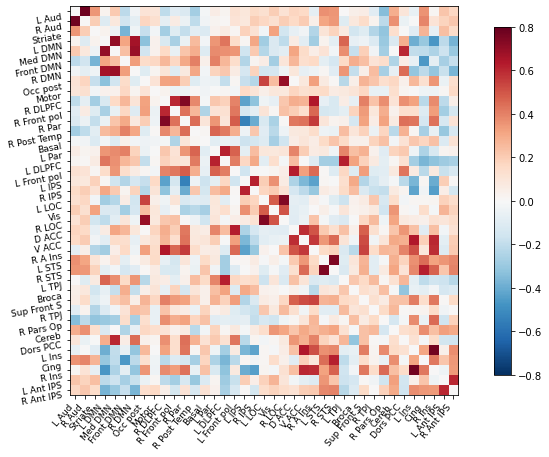

In [21]:
corrected_correlation_matrix = correlation_measure.fit_transform(
    [corrected_roi_time_series])[0]
np.fill_diagonal(corrected_correlation_matrix, 0)
fig = plt.figure(figsize=(8, 8))
plotting.plot_matrix(corrected_correlation_matrix, labels=msdl_atlas.labels,
                     vmax=0.8, vmin=-0.8, colorbar=True, figure=fig)
set_tick_label_size(fig, 9)

As before, we can also view this functional connectivity matrix as a connectome:

In [22]:
plotting.view_connectome(corrected_correlation_matrix, edge_threshold=0.2,
                         node_coords=msdl_atlas.region_coords)

In both the matrix and connectome forms, we can see a big difference when including the confounds!

<div class="alert alert-block alert-warning">
<b>Warning:</b> This is an important reminder to make sure that your data are cleaned of any possible sources of noise <em>before</em> running a machine learning analysis. Otherwise, you might be classifying participants on e.g. amount of head motion rather than a feature of interest!
</div>

## Conclusion

We reached the end of the second notebook of this tutorial which teached us how to build a connectome from fMRI data.

More specifically, we learned how to extract signals from fMRI volumes by defining regions of interests and using a masker object. We also learned how to use [`ConnectivityMeasure`](https://nilearn.github.io/modules/generated/nilearn.connectome.ConnectivityMeasure.html) objects to compute the strengths of connections. In addition to the [`datasets`](https://nilearn.github.io/modules/reference.html#module-nilearn.datasets), [`image`](https://nilearn.github.io/modules/reference.html#module-nilearn.image), and [`plotting`](https://nilearn.github.io/modules/reference.html#module-nilearn.plotting) modules from the first notebook, we discovered here the following modules:

- [`input_data`](https://nilearn.github.io/modules/reference.html#module-nilearn.input_data): Contains all maskers
- [`connectome`](https://nilearn.github.io/modules/reference.html#module-nilearn.connectome): Contains tools for computing functional connectivity matrices
